# Canine Cutaneous Tumor Segmentation

## Import packages

In [1]:
import sys 
sys.path.insert(0, '..')
from slide.process_slides import *
from fastai.vision import *
from torchvision import transforms

## Helper function to display patch-level results

In [2]:
def show_patch_results (learn, device, image_container, x_min, y_min, level, patch_size):
    lut = []
    lut.append([255, 255, 255]) # BG
    lut.append([0, 0, 255]) # Dermis
    lut.append([0, 255, 255]) # Epidermis 
    lut.append([255, 0, 0]) # Subcutis
    lut.append([255, 20, 147]) # Necrosis/Inflammation
    lut.append([255, 128, 0]) # Tumor
    lut = np.array(lut).astype(int)

    image = np.array(image_container.slide.read_region(location=(x_min, y_min), level=level, size=(patch_size, patch_size)))[:, :, :3]
    patch = pil2tensor(image / 255., np.float32)
    patch = transforms.Normalize(*learn.data.stats)(patch)
    gt = image_container.get_y_patch(x_min//np.power(4,level), y_min//np.power(4,level))

    with torch.no_grad():
        prediction = learn.model.eval()(torch.stack([patch]).to(device=device))
        prediction = torch.softmax(prediction, dim=1)
        prediction = prediction.argmax(dim=1)[None]
        prediction = np.squeeze(prediction.cpu(), 0)

        _, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
        ax[0].set_title("Image")
        ax[1].set_title("GT")
        ax[2].set_title("Prediction")

        ax[0].imshow(image)
        ax[1].imshow(lut[gt])
        ax[2].imshow(np.squeeze(lut[prediction], 0))
        
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

## Define model input parameters

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patch_size = 512
level = 2

## Define paths of slide folder and annotation JSON

In [4]:
target_folder = Path("E:/Slides/Canine Skin Tumors")
annotation_file = "E:/skin_tumors.json"

## Define dict to match annotation classes to classes used for training

In [5]:
label_dict = {'Bg': 0, 'Bone': -1, 'Cartilage': -1, 'Dermis': 1, 'Epidermis': 2, 'Subcutis': 3, 'Inflamm/Necrosis': 4,'Melanoma': 5, 'Plasmacytoma': 5,'Mast Cell Tumor': 5, 'PNST': 5, 'SCC': 5, 'Trichoblastoma': 5, 'Histiocytoma': 5}

## Load slide in custom SlideContainer format

In [6]:
slide = SlideContainer(Path(str(target_folder) + "/PNST/1654_16a_PNST_MF.svs"),annotation_file, level, patch_size, patch_size, dataset_type='segmentation', label_dict=label_dict)

## Load learner

In [7]:
segmentation_learner = load_learner(Path("../models"), "ResNet18_512_2_sdata.pkl")

## Let's have a look at some results

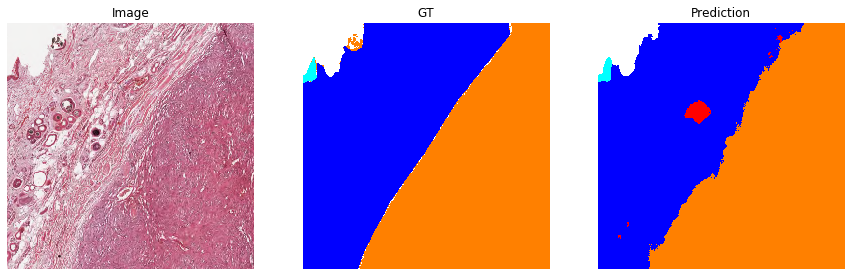

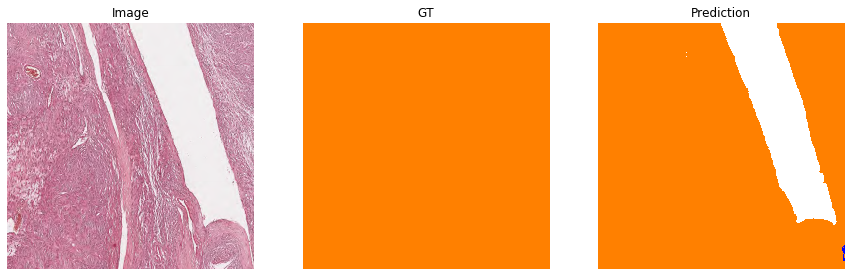

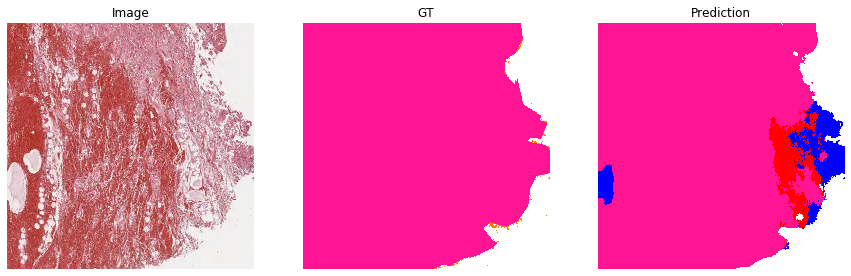

In [8]:
show_patch_results(segmentation_learner, device, slide, 10000, 35000, level, patch_size)
show_patch_results(segmentation_learner, device, slide, 80000, 60000, level, patch_size)
show_patch_results(segmentation_learner, device, slide, 100000, 65000, level, patch_size)
